In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]

In [3]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [4]:
from typing import Annotated

from langchain_cohere import ChatCohere
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = ChatCohere(model="command-r-plus")
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

In [5]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [6]:
from typing import Literal


def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile(checkpointer=memory)

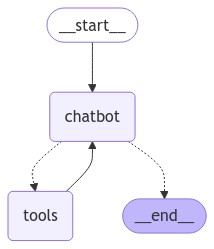

In [7]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
config = {"configurable": {"thread_id": "1"}}
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        events = graph.stream(
            {"messages": [("user", user_input)]}, config, stream_mode="values"
        )
        for event in events:
            event["messages"][-1].pretty_print()
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User:  hello


================================ Human Message =================================

hello
================================== Ai Message ==================================

Hi there! How can I help?


User:  my name is buse


================================ Human Message =================================

my name is buse
================================== Ai Message ==================================

Hi Buse!


User:  what is my name


================================ Human Message =================================

what is my name
================================== Ai Message ==================================

Your name is Buse.


User:  q


Goodbye!


In [10]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='hello', additional_kwargs={}, response_metadata={}, id='e32020d1-7c10-4b74-b175-e4d5531631fb'), AIMessage(content='Hi there! How can I help?', additional_kwargs={'documents': None, 'citations': None, 'search_results': None, 'search_queries': None, 'is_search_required': None, 'generation_id': '44d75b9c-0745-496d-ad1a-f11f0855a774', 'token_count': {'input_tokens': 979.0, 'output_tokens': 35.0}}, response_metadata={'documents': None, 'citations': None, 'search_results': None, 'search_queries': None, 'is_search_required': None, 'generation_id': '44d75b9c-0745-496d-ad1a-f11f0855a774', 'token_count': {'input_tokens': 979.0, 'output_tokens': 35.0}}, id='run-95e814a6-7000-4e88-8f02-e7dce5116278-0', usage_metadata={'input_tokens': 979, 'output_tokens': 35, 'total_tokens': 1014}), HumanMessage(content='my name is buse', additional_kwargs={}, response_metadata={}, id='1799ab39-083a-442c-b73b-2c68faccedfc'), AIMessage(content='Hi Buse!', add